# Use Gemini Flash to predict the main address

# Determine stable address with Gemini Flash 2.5

In [35]:
import pandas as pd

clustered_data_with_matched_addresses = pd.read_csv("../datasets/filtered_data_with_matched_addresses.csv")


In [ ]:
import pandas as pd


filtered_data = (
    clustered_data_with_matched_addresses
    .sort_values(['caid', 'quarter', 'total_pings'], ascending=[True, True, False])
    .groupby(['caid', 'quarter'])
    .head(5)
    .copy()
)

filtered_data.shape

In [16]:
import random

# Select 250 devices
selected_caids = random.sample(list(filtered_data["caid"].unique()), 250)
labeled_df = filtered_data[filtered_data["caid"].isin(selected_caids)].copy()
unlabeled_df = filtered_data[~filtered_data["caid"].isin(selected_caids)].copy()


In [27]:
unlabeled_df.to_csv("../datasets/unlabeled_data.csv")

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed
from pydantic import BaseModel, Field, ValidationError

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI


# ----------------------------
# Load API key and init Gemini
# ----------------------------
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# ----------------------------
# Define output schema
# ----------------------------
class MainClusterSelection(BaseModel):
    main_cluster: int = Field(description="Cluster number selected as main address")
    justification: str = Field(description="Why this cluster was selected")

parser = PydanticOutputParser(pydantic_object=MainClusterSelection)

# ----------------------------
# Prompt template
# ----------------------------
prompt = PromptTemplate(
    template="""
Each user (identified by a CAID) has multiple location clusters detected from mobile signals. Each cluster represents a place where the user spent time during the quarter.

Your task is to reason through the features provided and select the **single cluster most likely to represent the user’s primary home address** for that quarter.

Home addresses tend to follow natural behavioral patterns: people typically sleep there, spend time in the evenings, and show consistent presence across the week. A home cluster will usually have high **night** or **evening** consistency, appear on many different days, span across many hours of the day, and show longer uninterrupted stays. We also expect home clusters to have broader time window coverage and account for a large portion of total pings.

You don’t need to follow a strict rule — just reason like a human would. If you had to bet which cluster is the user’s home, based on how they behave there and how often they show up, what would you choose?

Focus on the strongest overall signal across all features. If no single cluster is clearly dominant, choose the one that seems most likely to be a residence over a workplace or other location. Then explain your reasoning.

---

### Column Descriptions

cluster: Cluster index for this user  
consistency_score: % of days (midnight to midnight) this cluster was seen  
night_consistency_score: % of nights this cluster was seen (NaN if no night pings)  
evening_consistency_score: % of evenings this cluster was seen (NaN if no evening pings)  
day_consistency_score: % of daytime days (8am–8pm) this cluster was seen (NaN if no day pings)  
dominance_score: % of device pings in this cluster  
total_pings: Total number of pings in this cluster  
unique_hours: Number of unique hourly bins this cluster was active  
hour_entropy: Entropy of hourly activity (NaN if too few pings)  
max_consecutive_hours: Longest streak of consecutive hourly bins with activity in one cluster (silent hours ignored)  
time_window_coverage: Fraction of [day, evening, night] windows with activity

---

### Cluster Candidates

{cluster_table}

Choose the main_cluster and explain why.

{format_instructions}
""",
    input_variables=["cluster_table"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

# ----------------------------
# Format one CAID’s cluster group
# ----------------------------
def format_cluster_group(group):
    return "\n".join([
        f"cluster: {row['cluster']}, "
        f"consistency_score: {row['consistency_score']}, "
        f"night_consistency_score: {row['night_consistency_score']}, "
        f"evening_consistency_score: {row['evening_consistency_score']}, "
        f"day_consistency_score: {row['day_consistency_score']}, "
        f"dominance_score: {row['dominance_score']}, "
        f"total_pings: {row['total_pings']}, "
        f"unique_hours: {row['unique_hours']}, "
        f"hour_entropy: {row['hour_entropy']}, "
        f"max_consecutive_hours: {row['max_consecutive_hours']}, "
        f"time_window_coverage: {row['time_window_coverage']}"
        for _, row in group.iterrows()
    ])

# ----------------------------
# LLM call for one user
# ----------------------------
def decide_main_cluster(caid, group):
    try:
        table = format_cluster_group(group)
        output = chain.invoke({"cluster_table": table})
        return {
            "caid": caid,
            "quarter": group.iloc[0]["quarter"],
            "cluster": output.main_cluster,
            "is_main_address_gemini_top5": 1,
            "main_address_justification_gemini_top5": output.justification
        }
    except Exception as e:
        print(f"❌ Error for caid {caid}: {e}")
        return None

# ----------------------------
# Threaded Gemini call for each CAID
# ----------------------------
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(decide_main_cluster, caid, group): caid
        for (caid, quarter), group in labeled_df.groupby(["caid", "quarter"])
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="Gemini (Top 5)"):
        result = future.result()
        if result:
            results.append(result)

# ----------------------------
# Merge results and save
# ----------------------------
df_results = pd.DataFrame(results)
df_labeled = labeled_df.merge(df_results, on=["caid", "quarter", "cluster"], how="left")

df_labeled["is_main_address_gemini_top5"] = df_labeled["is_main_address_gemini_top5"].fillna(0).astype(int)
df_labeled["main_address_justification_gemini_top5"] = df_labeled["main_address_justification_gemini_top5"].fillna("")

df_labeled.to_csv("../datasets/250_labeled_data_with_main_address.csv", index=False)



📦 Processing Quarter 2...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

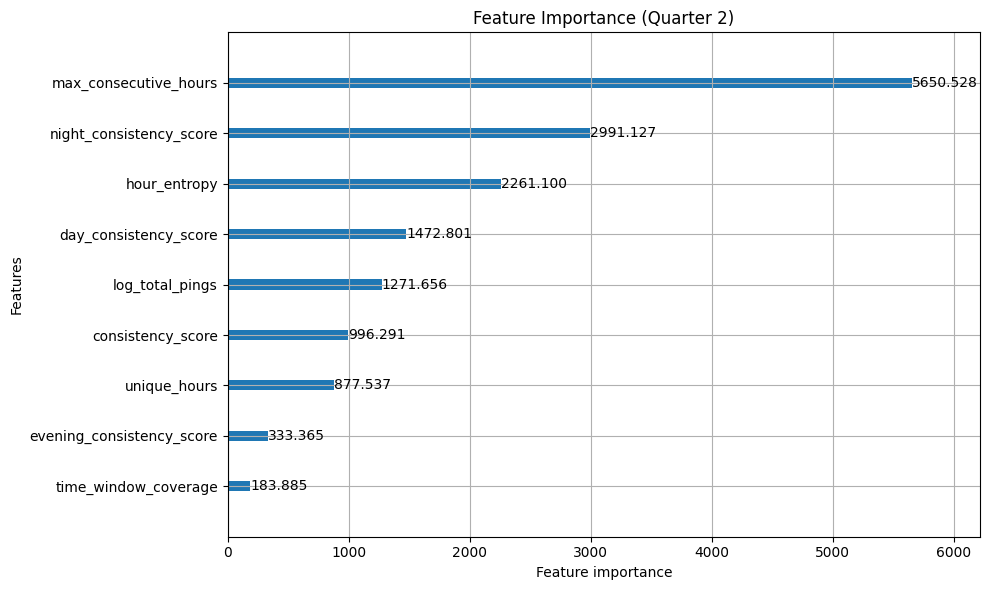


📦 Processing Quarter 5...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

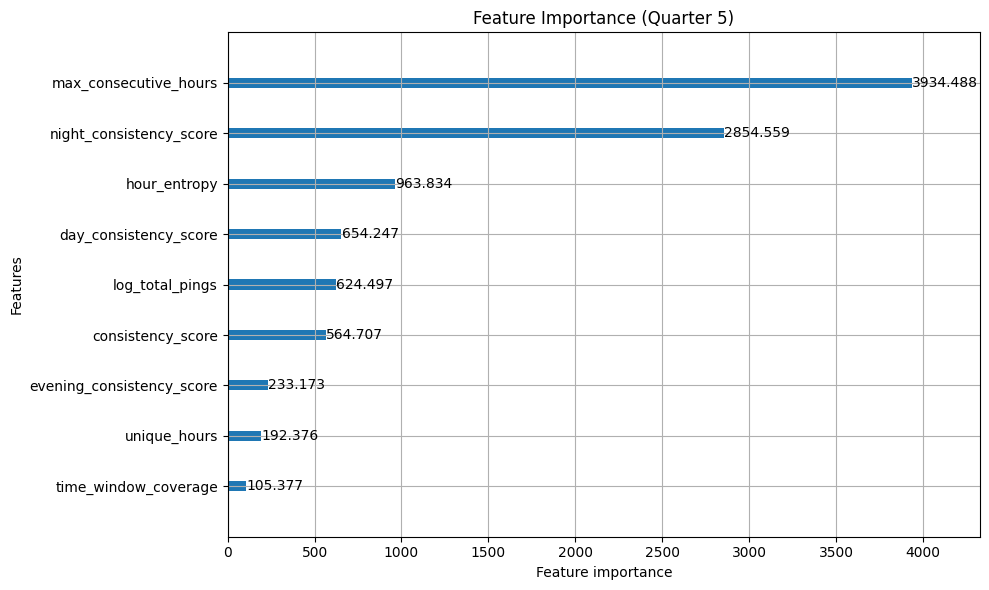


📦 Processing Quarter 8...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

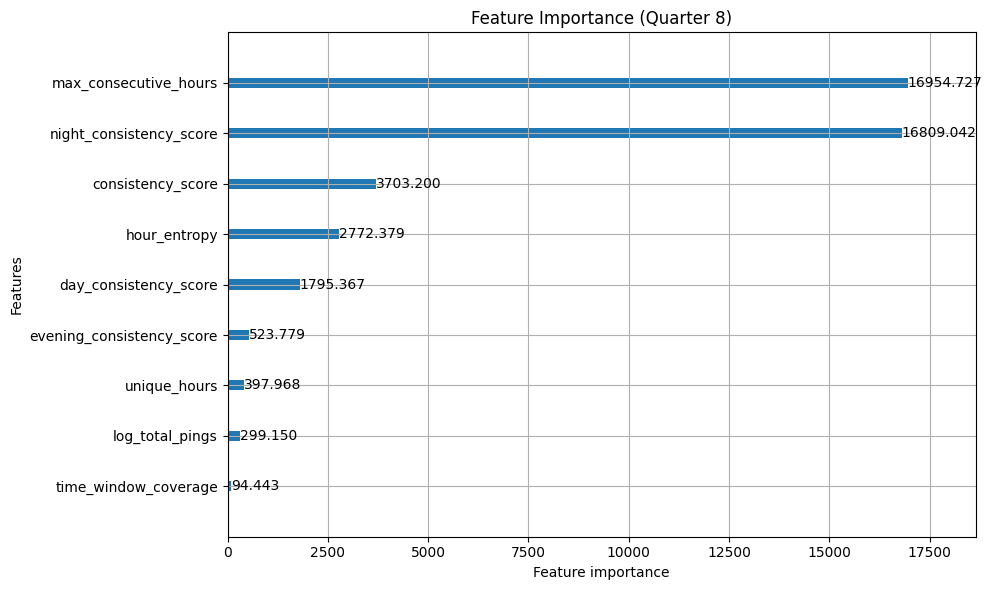


📦 Processing Quarter 11...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidat

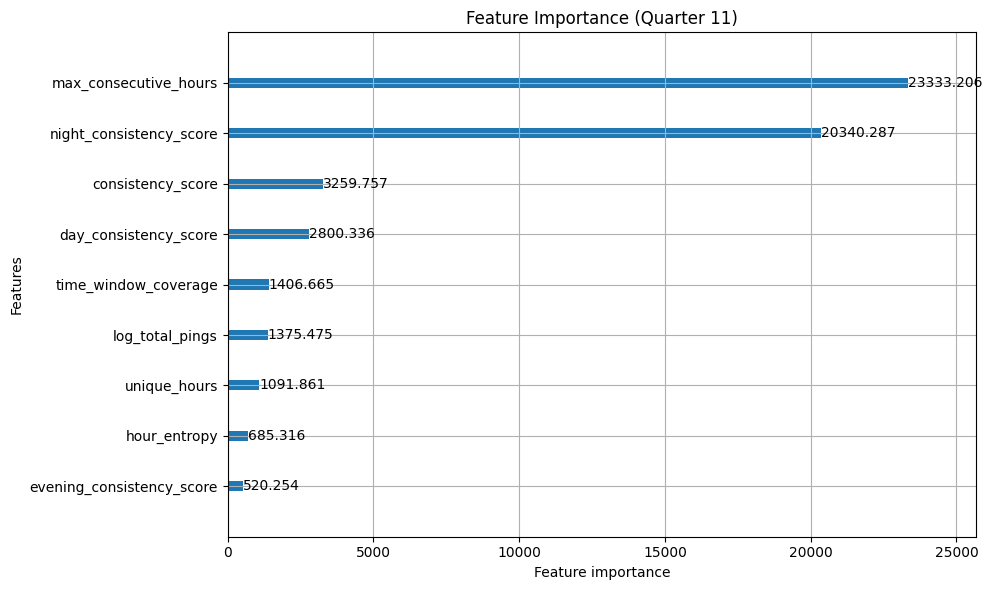

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import lightgbm as lgb

# ---------------------------
# Load labeled and unlabeled data
# ---------------------------
df_labeled = pd.read_csv("../datasets/250_labeled_data_with_main_address.csv")
unlabeled_df = pd.read_csv("../datasets/unlabeled_data.csv")

features = [
    'day_consistency_score', 'evening_consistency_score', 'night_consistency_score',
    'log_total_pings', 'consistency_score', 'unique_hours', 'max_consecutive_hours', 'time_window_coverage','hour_entropy','dominance_score',
]
target = "is_main_address_gemini_top5"

# ---------------------------
# Train and predict for each quarter
# ---------------------------
all_predictions = []

for quarter in sorted(df_labeled["quarter"].unique()):
    print(f"\n📦 Processing Quarter {quarter}...")

    train_data = df_labeled[df_labeled["quarter"] == quarter].copy()
    test_data = unlabeled_df[unlabeled_df["quarter"] == quarter].copy()

    X_train = train_data[features]
    y_train = train_data[target]

    X_test = test_data[features]

    # Cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Bayesian optimization search space
    param_space = {
        'n_estimators': Integer(1, 500),
        'max_depth': Integer(3, 15),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'subsample': Real(0.7, 0.9),
        'colsample_bytree': Real(0.7, 0.9),
        'class_weight': Categorical([None, 'balanced'])
    }

    print("🔍 Running Bayesian optimization with LightGBM...")
    model = LGBMClassifier(objective='binary', random_state=42, verbosity=-1)
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        n_iter=30,
        scoring='f1',
        cv=cv_strategy,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)


    best_model = bayes_search.best_estimator_


    # Plot feature importance
    lgb.plot_importance(best_model, max_num_features=15, importance_type="gain", figsize=(10, 6))
    plt.title(f"Feature Importance (Quarter {quarter})")
    plt.tight_layout()
    plt.show()

    test_data["pred_score"] = best_model.predict_proba(X_test)[:, 1]
    test_data["pred_rank"] = test_data.groupby("caid")["pred_score"].rank("dense", ascending=False)
    test_data["pred_is_main"] = (test_data["pred_rank"] == 1).astype(int)
    test_data["is_main_address"] = test_data["pred_is_main"]
    test_data["main_address_justification"] = "Predicted by LightGBM"

    all_predictions.append(test_data)

df_predicted = pd.concat(all_predictions, ignore_index=True)


In [53]:
# ---------------------------
# Combine predictions and save
# ---------------------------

# Add label-based pred_score for labeled data
df_labeled["is_main_address"] = df_labeled[target]
df_labeled["pred_score"] = df_labeled["is_main_address"]

# Unify justification column
df_labeled["main_address_justification"] = df_labeled["main_address_justification_gemini_top5"].fillna("")
df_predicted["main_address_justification"] = df_predicted["main_address_justification"].fillna("")

# Drop the temporary justification column from labeled so it doesn't clash
if "main_address_justification_gemini_top5" in df_labeled.columns:
    df_labeled = df_labeled.drop(columns=["main_address_justification_gemini_top5"])

# Align columns manually (not by intersecting) — just select what you want
keep_cols = features + ["caid", "quarter", "cluster", "pred_score", "is_main_address", "main_address_justification"]

df_labeled_final = df_labeled[keep_cols]
df_predicted_final = df_predicted[keep_cols]

# Concatenate
final_df = pd.concat([df_labeled_final, df_predicted_final], ignore_index=True)

# Drop extra columns if they exist
final_df = final_df.drop(columns=["Unnamed: 0", "pred_rank", "pred_is_main"], errors="ignore")

# Save
final_df.to_csv("../datasets/no_dominance_main_address_predictions_combined_bayesopt.csv", index=False)
print("✅ Combined results saved to '../no_dominance_datasets/main_address_predictions_combined_bayesopt.csv'")


✅ Combined results saved to '../no_dominance_datasets/main_address_predictions_combined_bayesopt.csv'


In [54]:
final_df

,day_consistency_score,evening_consistency_score,night_consistency_score,log_total_pings,consistency_score,unique_hours,max_consecutive_hours,time_window_coverage,hour_entropy,caid,quarter,cluster,pred_score,is_main_address,main_address_justification
0,0.000000,0.00,0.285714,3.891820,0.181818,2,1,0.333333,0.376770,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,4,0.000000,0,
1,0.285714,0.00,0.142857,2.944439,0.181818,4,4,0.666667,1.223576,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,17,0.000000,0,
2,0.285714,0.00,0.285714,2.772589,0.272727,7,9,0.666667,1.621668,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,3,1.000000,1,Cluster 3 is selected as the most likely home ...
3,0.000000,0.25,0.000000,2.639057,0.090909,1,0,0.333333,NaN,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,6,0.000000,0,
4,0.000000,0.00,0.285714,2.302585,0.181818,1,1,0.333333,NaN,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,13,0.000000,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158712,0.200000,0.00,0.000000,1.098612,0.125000,1,1,0.333333,NaN,fff4905cc761648ce58f6619c4cd748a7f313a5eeab427...,11,16,0.005380,0,Predicted by LightGBM
158713,0.000000,1.00,0.000000,0.693147,0.125000,1,1,0.333333,NaN,fff4905cc761648ce58f6619c4cd748a7f313a5eeab427...,11,19,0.006092,0,Predicted by LightGBM
158714,0.500000,NaN,0.500000,2.772589,0.500000,3,185,0.666667,1.098612,fff69f2c3d3654fe4c681a975039091800baaa1af1e267...,11,1,0.912352,1,Predicted by LightGBM
158715,0.500000,NaN,0.500000,2.639057,0.500000,3,24,0.666667,1.012331,fff69f2c3d3654fe4c681a975039091800baaa1af1e267...,11,2,0.898556,0,Predicted by LightGBM


In [55]:
# Reorder to put caid, quarter, cluster first
first_cols = ["caid", "quarter", "cluster"]
remaining_cols = [col for col in final_df.columns if col not in first_cols]
final_df = final_df[first_cols + remaining_cols]


In [56]:
final_df

,caid,quarter,cluster,day_consistency_score,evening_consistency_score,night_consistency_score,log_total_pings,consistency_score,unique_hours,max_consecutive_hours,time_window_coverage,hour_entropy,pred_score,is_main_address,main_address_justification
0,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,4,0.000000,0.00,0.285714,3.891820,0.181818,2,1,0.333333,0.376770,0.000000,0,
1,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,17,0.285714,0.00,0.142857,2.944439,0.181818,4,4,0.666667,1.223576,0.000000,0,
2,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,3,0.285714,0.00,0.285714,2.772589,0.272727,7,9,0.666667,1.621668,1.000000,1,Cluster 3 is selected as the most likely home ...
3,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,6,0.000000,0.25,0.000000,2.639057,0.090909,1,0,0.333333,NaN,0.000000,0,
4,005b8610429d109779b0d3ed6761db6dce472d0c6a171a...,2,13,0.000000,0.00,0.285714,2.302585,0.181818,1,1,0.333333,NaN,0.000000,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158712,fff4905cc761648ce58f6619c4cd748a7f313a5eeab427...,11,16,0.200000,0.00,0.000000,1.098612,0.125000,1,1,0.333333,NaN,0.005380,0,Predicted by LightGBM
158713,fff4905cc761648ce58f6619c4cd748a7f313a5eeab427...,11,19,0.000000,1.00,0.000000,0.693147,0.125000,1,1,0.333333,NaN,0.006092,0,Predicted by LightGBM
158714,fff69f2c3d3654fe4c681a975039091800baaa1af1e267...,11,1,0.500000,NaN,0.500000,2.772589,0.500000,3,185,0.666667,1.098612,0.912352,1,Predicted by LightGBM
158715,fff69f2c3d3654fe4c681a975039091800baaa1af1e267...,11,2,0.500000,NaN,0.500000,2.639057,0.500000,3,24,0.666667,1.012331,0.898556,0,Predicted by LightGBM


In [57]:
final_df.to_csv("../datasets/no_dominance_main_address_predictions_combined_bayesopt.csv", index=False)


# Evaluate the F1-score


📦 Processing Quarter 2...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

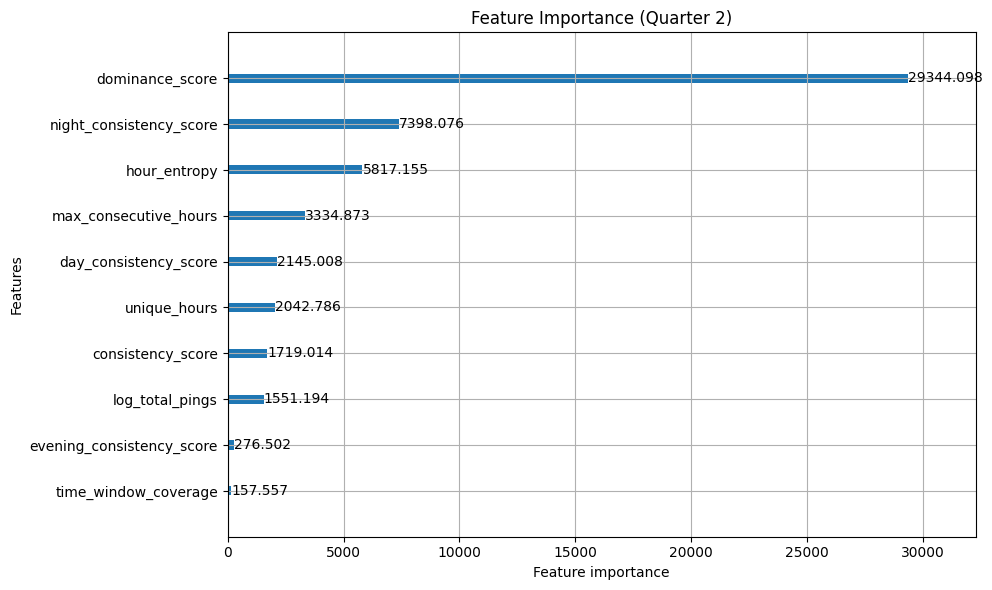


📦 Processing Quarter 5...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

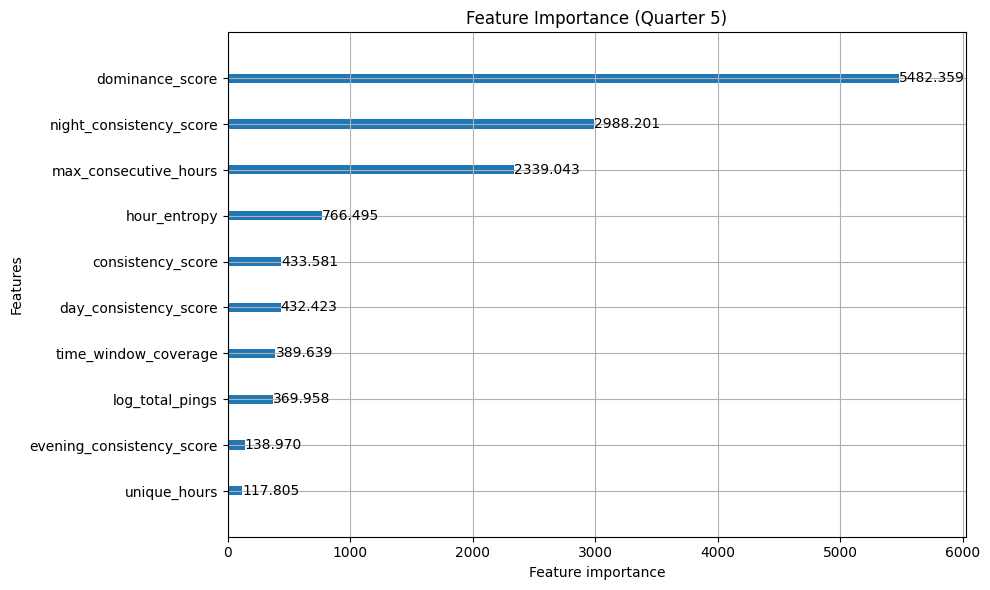


📦 Processing Quarter 8...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidate

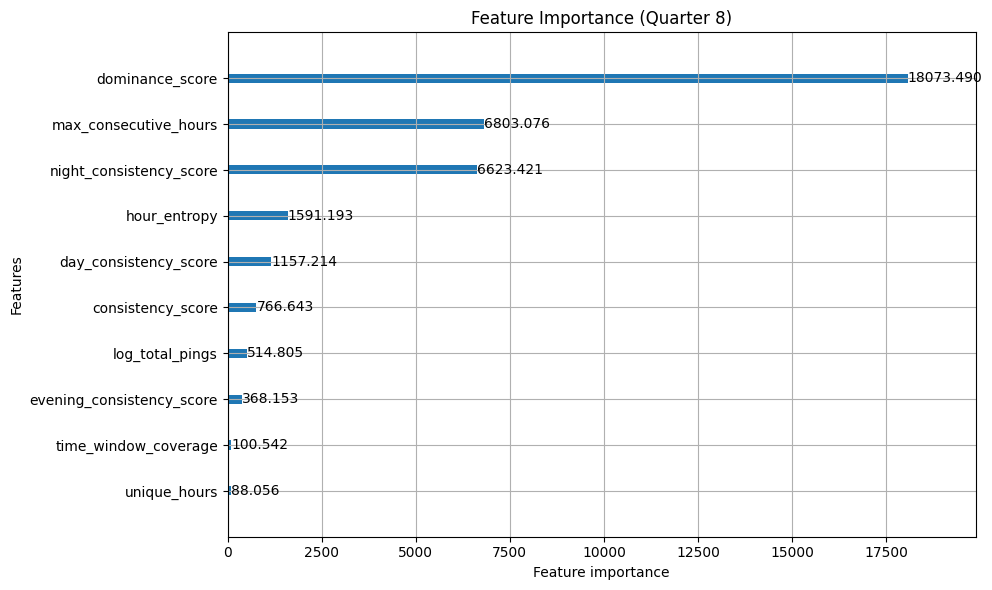


📦 Processing Quarter 11...
🔍 Running Bayesian optimization with LightGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidat

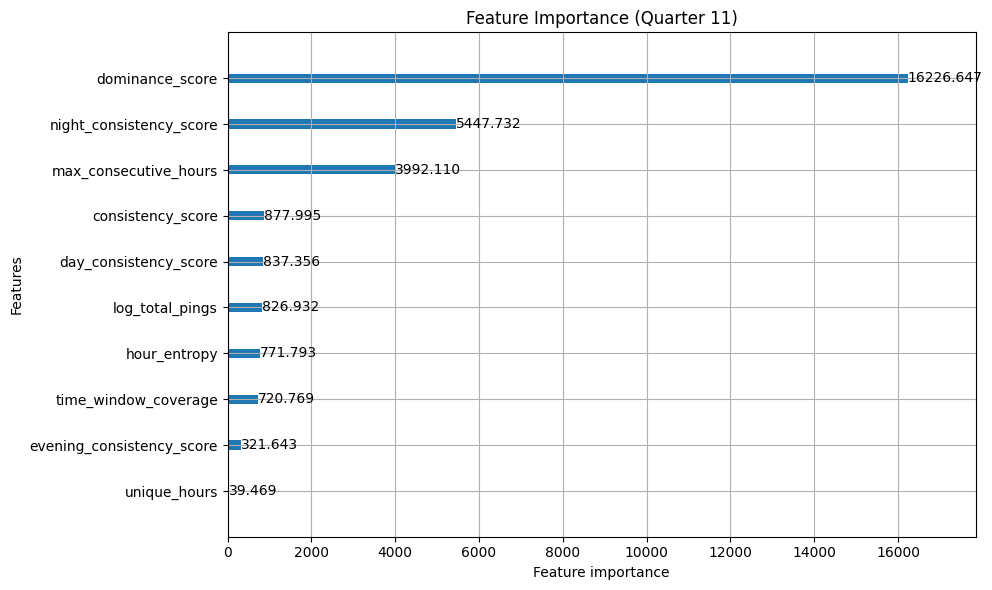


📋 Summary of F1 Scores per Quarter:
Quarter 2: F1-score = 0.9400
Quarter 5: F1-score = 0.9200
Quarter 8: F1-score = 0.9200
Quarter 11: F1-score = 0.8713

🔵 Average F1-score across all quarters: 0.9128


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb

# ---------------------------
# Load labeled data
# ---------------------------
df_labeled = pd.read_csv("../datasets/250_labeled_data_with_main_address.csv")

features = [
    'day_consistency_score', 'evening_consistency_score', 'night_consistency_score',
    'log_total_pings', 'consistency_score', 'unique_hours', 'max_consecutive_hours',
    'time_window_coverage', 'hour_entropy', 'dominance_score',
]
target = "is_main_address_gemini_top5"

# ---------------------------
# Train and Evaluate per Quarter
# ---------------------------
all_f1_scores = []

for quarter in sorted(df_labeled["quarter"].unique()):
    print(f"\n📦 Processing Quarter {quarter}...")

    quarter_data = df_labeled[df_labeled["quarter"] == quarter].copy()

    # Select the list of caids
    unique_caids = quarter_data["caid"].unique()

    # 80%/20% split based on caid
    caid_train, caid_valid = train_test_split(
        unique_caids, test_size=0.2, random_state=42
    )

    # Filter datasets
    train_data = quarter_data[quarter_data["caid"].isin(caid_train)].copy()
    valid_data = quarter_data[quarter_data["caid"].isin(caid_valid)].copy()

    X_train = train_data[features]
    y_train = train_data[target]

    X_valid = valid_data[features]
    y_valid = valid_data[[target, "caid"]].copy()

    # Cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Bayesian optimization search space
    param_space = {
        'n_estimators': Integer(1, 500),
        'max_depth': Integer(1, 15),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'subsample': Real(0.5, 0.9),
        'colsample_bytree': Real(0.5, 0.9),
        'class_weight': Categorical([None, 'balanced'])
    }

    print("🔍 Running Bayesian optimization with LightGBM...")
    model = LGBMClassifier(objective='binary', random_state=42, verbosity=-1)
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        n_iter=30,
        scoring='f1',
        cv=cv_strategy,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)

    best_model = bayes_search.best_estimator_

    # Predict on validation set
    valid_data["pred_score"] = best_model.predict_proba(X_valid)[:, 1]
    valid_data["pred_rank"] = valid_data.groupby("caid")["pred_score"].rank("dense", ascending=False)
    valid_data["pred_is_main"] = (valid_data["pred_rank"] == 1).astype(int)

    # Evaluate row-by-row (all 250 rows)
    y_true = valid_data[target]
    y_pred = valid_data["pred_is_main"]

    # Row-level F1 and confusion matrix
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Save F1
    all_f1_scores.append((quarter, f1))

    print(f"\n🧮 Row-Level Confusion Matrix for Quarter {quarter}:\n")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))

    print(f"\n🧮 Confusion Matrix for Quarter {quarter}:\n")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"]))


    print(f"📈 Quarter {quarter} - F1 Score: {f1:.4f}")

    # Plot feature importance
    lgb.plot_importance(best_model, max_num_features=15, importance_type="gain", figsize=(10, 6))
    plt.title(f"Feature Importance (Quarter {quarter})")
    plt.tight_layout()
    plt.show()

# ---------------------------
# Summary
# ---------------------------
print("\n📋 Summary of F1 Scores per Quarter:")
for quarter, f1 in all_f1_scores:
    print(f"Quarter {quarter}: F1-score = {f1:.4f}")

average_f1 = np.mean([f for _, f in all_f1_scores])
print(f"\n🔵 Average F1-score across all quarters: {average_f1:.4f}")
